In [0]:
from google.colab import drive

In [41]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!ls "/content/drive/My Drive/"

'Getting started.pdf'   projects


In [43]:
!pip3 install torch torchvision

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()
path = "/content/drive/My Drive/projects/Text-to-Image-Generation-using-Conditonal-GAN"
import os
os.chdir(path)


In [45]:
ls


cond_gan.png       fashion-mnist_train.csv  generator.pkl
discriminator.pkl  GAN_mnist.ipynb          README.md


In [0]:
import pandas as pd

In [0]:
df_train=pd.read_csv('./fashion-mnist_train.csv')

In [48]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [0]:
y_train=df_train['label']

In [0]:
x_train=df_train.loc[:,df_train.columns!="label"]/255

In [51]:
len(df_train)

60000

In [0]:
import torch
import torch.utils.data
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.2)

In [0]:
x_train_tensor=torch.from_numpy(x_train.values)
y_train_tensor=torch.from_numpy(y_train.values).type(torch.LongTensor)
x_test_tensor=torch.from_numpy(x_test.values)
y_test_tensor=torch.from_numpy(y_test.values).type(torch.LongTensor)

In [0]:
train_dataset=torch.utils.data.TensorDataset(x_train_tensor,y_train_tensor)
test_dataset=torch.utils.data.TensorDataset(x_test_tensor,y_test_tensor)

In [0]:
batch_size=1
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
      x=x.view(x.size(0),784)
      c=self.label_emb(labels)
      x=torch.cat([x,c],1)
      out=self.model(x)
      return out.squeeze()
      
      
      

In [0]:
class Generator(nn.Module):
  def __init__(self):
    
    super().__init__()
    
    
    self.label_emb=nn.Embedding(10,10)
    
    self.model=nn.Sequential(
        nn.Linear(110,256),
        nn.LeakyReLU(0.2,inplace=True),
        #nn.Dropout(0.3),
        nn.Linear(256,512),
        nn.LeakyReLU(0.2,inplace=True),
        #nn.Dropout(0.3),
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2,inplace=True),
        #nn.Dropout(0.3),
        nn.Linear(1024,784),
        nn.Tanh()
    
    )
    
  def forward(self,z,labels):
    z=z.view(z.size(0),100)
    c=self.label_emb(labels)
    x=torch.cat([z,c],1)
    out=self.model(x)
    return out.view(out.size(0),28,28)
    
    
      
  

In [0]:
def params(model):
  pytorch_total_params = sum(p.numel() for p in model.parameters())
  return pytorch_total_params

In [66]:
generator=Generator().cuda()
print(generator)
print(params(generator))
discriminator=Discriminator().cuda()
print(discriminator)
print(params(discriminator))

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
1489012
Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout(p=0.3)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Dropout(p=0.3)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Dropout(p=0.3)
    (9): Linear(in_features=256, o

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [0]:
def func(n,end= 10,start= 0):
    return (list(range(start, n))) + (list(range(n+1, end)))

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    #train with real images and fake labels
    not_real_labels=Variable(torch.LongTensor(np.array([random.choice(func(label)) for label in labels]))).cuda()
    wrong_label_validity=discriminator(real_images,not_real_labels)
    wrong_label_loss=criterion(wrong_label_validity,Variable(torch.zeros(batch_size)).cuda())
    
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss+wrong_label_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
8it [00:00, 77.79it/s]

Starting epoch 0...


48000it [07:19, 109.19it/s]


g_loss: 0.6622762084007263, d_loss: 1.0427242517471313


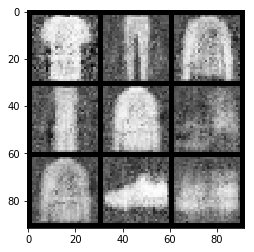

Starting epoch 1...

10it [00:00, 97.11it/s]

48000it [07:12, 111.51it/s]


g_loss: 0.9528046250343323, d_loss: 1.1862561702728271


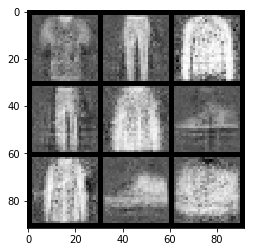

0it [00:00, ?it/s]

Starting epoch 2...


48000it [07:10, 111.60it/s]


g_loss: 1.8666921854019165, d_loss: 2.1861629486083984


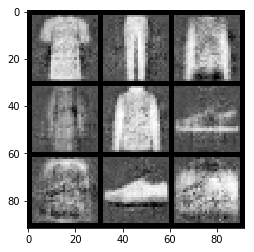

0it [00:00, ?it/s]

Starting epoch 3...


48000it [07:10, 111.51it/s]


g_loss: 1.0876572132110596, d_loss: 1.7030789852142334


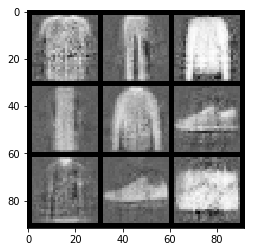

0it [00:00, ?it/s]

Starting epoch 4...


48000it [07:07, 112.22it/s]


g_loss: 1.1972193717956543, d_loss: 1.0120611190795898


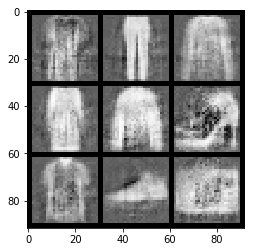

0it [00:00, ?it/s]

Starting epoch 5...


48000it [07:08, 111.94it/s]


g_loss: 0.7114480137825012, d_loss: 1.1467812061309814


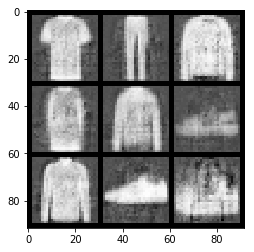

10it [00:00, 98.15it/s]

Starting epoch 6...


48000it [07:10, 112.01it/s]


g_loss: 1.5635238885879517, d_loss: 0.8492165207862854


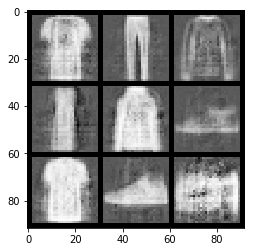

0it [00:00, ?it/s]

Starting epoch 7...


48000it [07:09, 111.76it/s]


g_loss: 0.9954574108123779, d_loss: 0.7917966842651367


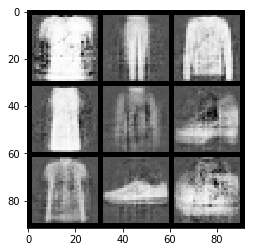

0it [00:00, ?it/s]

Starting epoch 8...


48000it [07:07, 112.35it/s]


g_loss: 2.953887701034546, d_loss: 0.6714850068092346


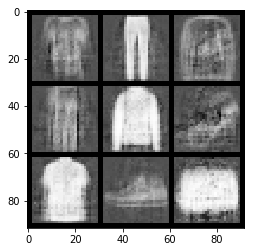

0it [00:00, ?it/s]

Starting epoch 9...


48000it [06:58, 114.57it/s]


g_loss: 0.9551737308502197, d_loss: 0.6534391641616821


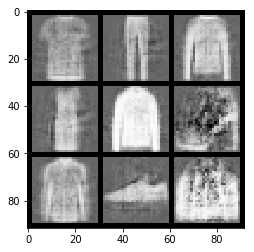

0it [00:00, ?it/s]

Starting epoch 10...


48000it [06:58, 114.76it/s]


g_loss: 1.8290889263153076, d_loss: 1.093529462814331


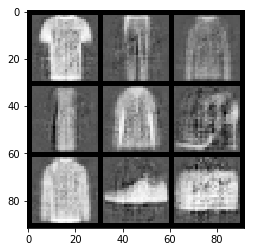

0it [00:00, ?it/s]

Starting epoch 11...


48000it [06:59, 114.46it/s]


g_loss: 0.8316499590873718, d_loss: 0.18254543840885162


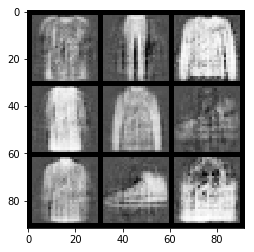

0it [00:00, ?it/s]

Starting epoch 12...


48000it [06:58, 114.58it/s]


g_loss: 1.3715341091156006, d_loss: 1.42763090133667


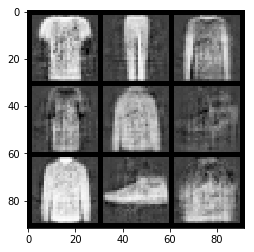

0it [00:00, ?it/s]

Starting epoch 13...


48000it [07:10, 111.60it/s]


g_loss: 3.562832832336426, d_loss: 1.17304527759552


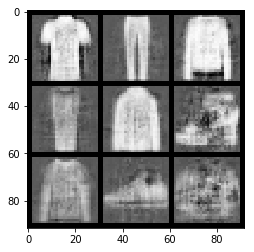

0it [00:00, ?it/s]

Starting epoch 14...


48000it [07:10, 111.54it/s]


g_loss: 1.5921729803085327, d_loss: 0.21929126977920532


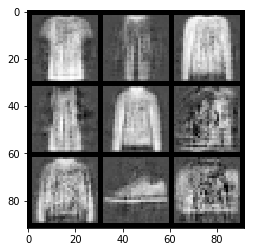

0it [00:00, ?it/s]

Starting epoch 15...


48000it [07:12, 111.01it/s]


g_loss: 2.618361234664917, d_loss: 1.3539047241210938


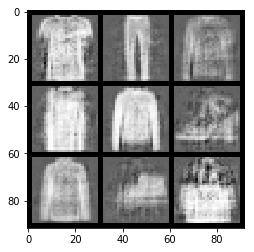

0it [00:00, ?it/s]

Starting epoch 16...


48000it [07:12, 110.91it/s]


g_loss: 3.1090259552001953, d_loss: 0.1681458204984665


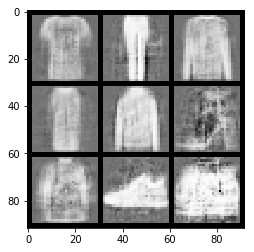

0it [00:00, ?it/s]

Starting epoch 17...


48000it [07:10, 111.43it/s]


g_loss: 1.0705418586730957, d_loss: 1.006044626235962


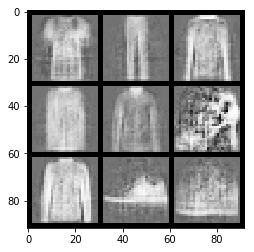

0it [00:00, ?it/s]

Starting epoch 18...


48000it [07:13, 110.62it/s]


g_loss: 1.2817213535308838, d_loss: 0.8140904307365417


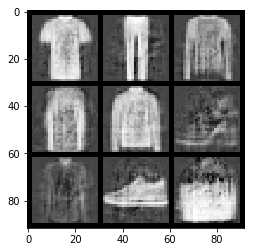

0it [00:00, ?it/s]

Starting epoch 19...


27934it [04:13, 107.88it/s]

Buffered data was truncated after reaching the output size limit.

In [0]:
import random
from tqdm import tqdm
n_critic = 5
display_step = 300
num_epochs=20
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        real_images = Variable(images.float()).cuda()
        #grid = make_grid(real_images, nrow=10, normalize=True).permute(1,2,0).numpy()
        #plt.imshow(grid)
        #plt.show()
        
        labels = Variable(labels).cuda()
        discriminator.train()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

In [0]:
torch.save(generator, "generator.pkl")
torch.save(discriminator,"discriminator.pkl")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# run this cell for testing only
generator = torch.load('generator.pkl')

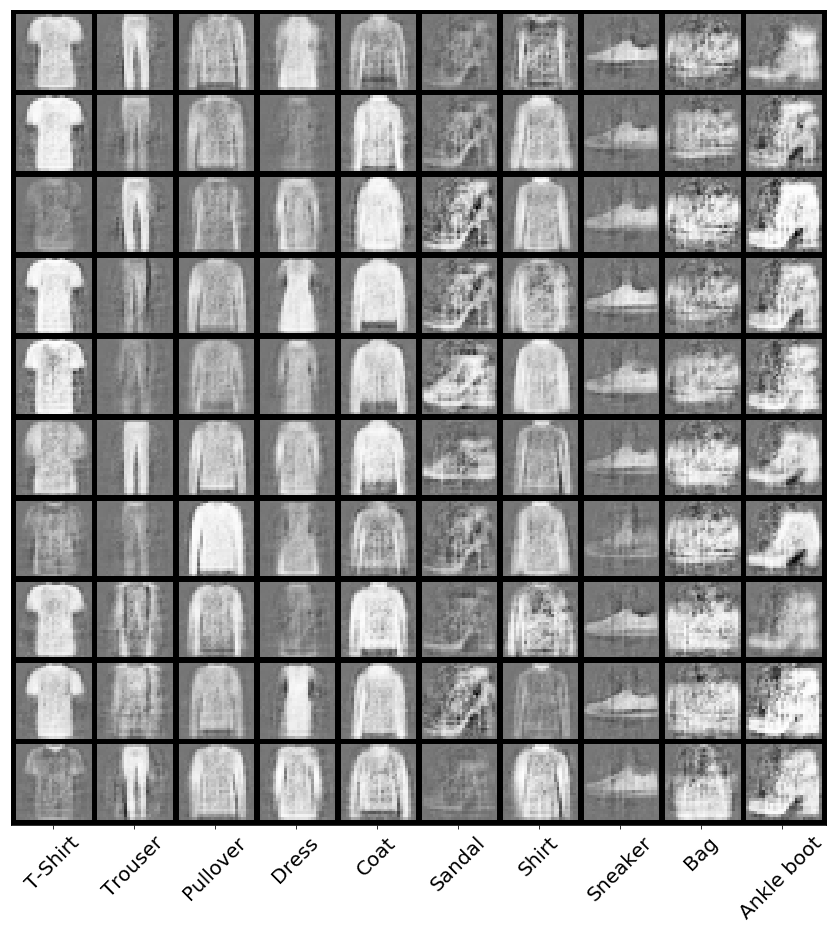

In [72]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)
plt.savefig('cgan_test.png')